In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [3]:
model = models.vgg16(pretrained=True)

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.modules())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Total convolution layers: 13
conv_layers


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

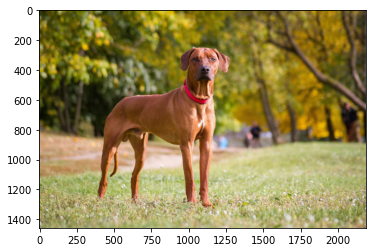

In [6]:
from PIL import Image
image = Image.open(str('dog.jpg'))
plt.imshow(image)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [8]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [9]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

13
torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])
torch.Size([1, 512, 224, 224])


In [10]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


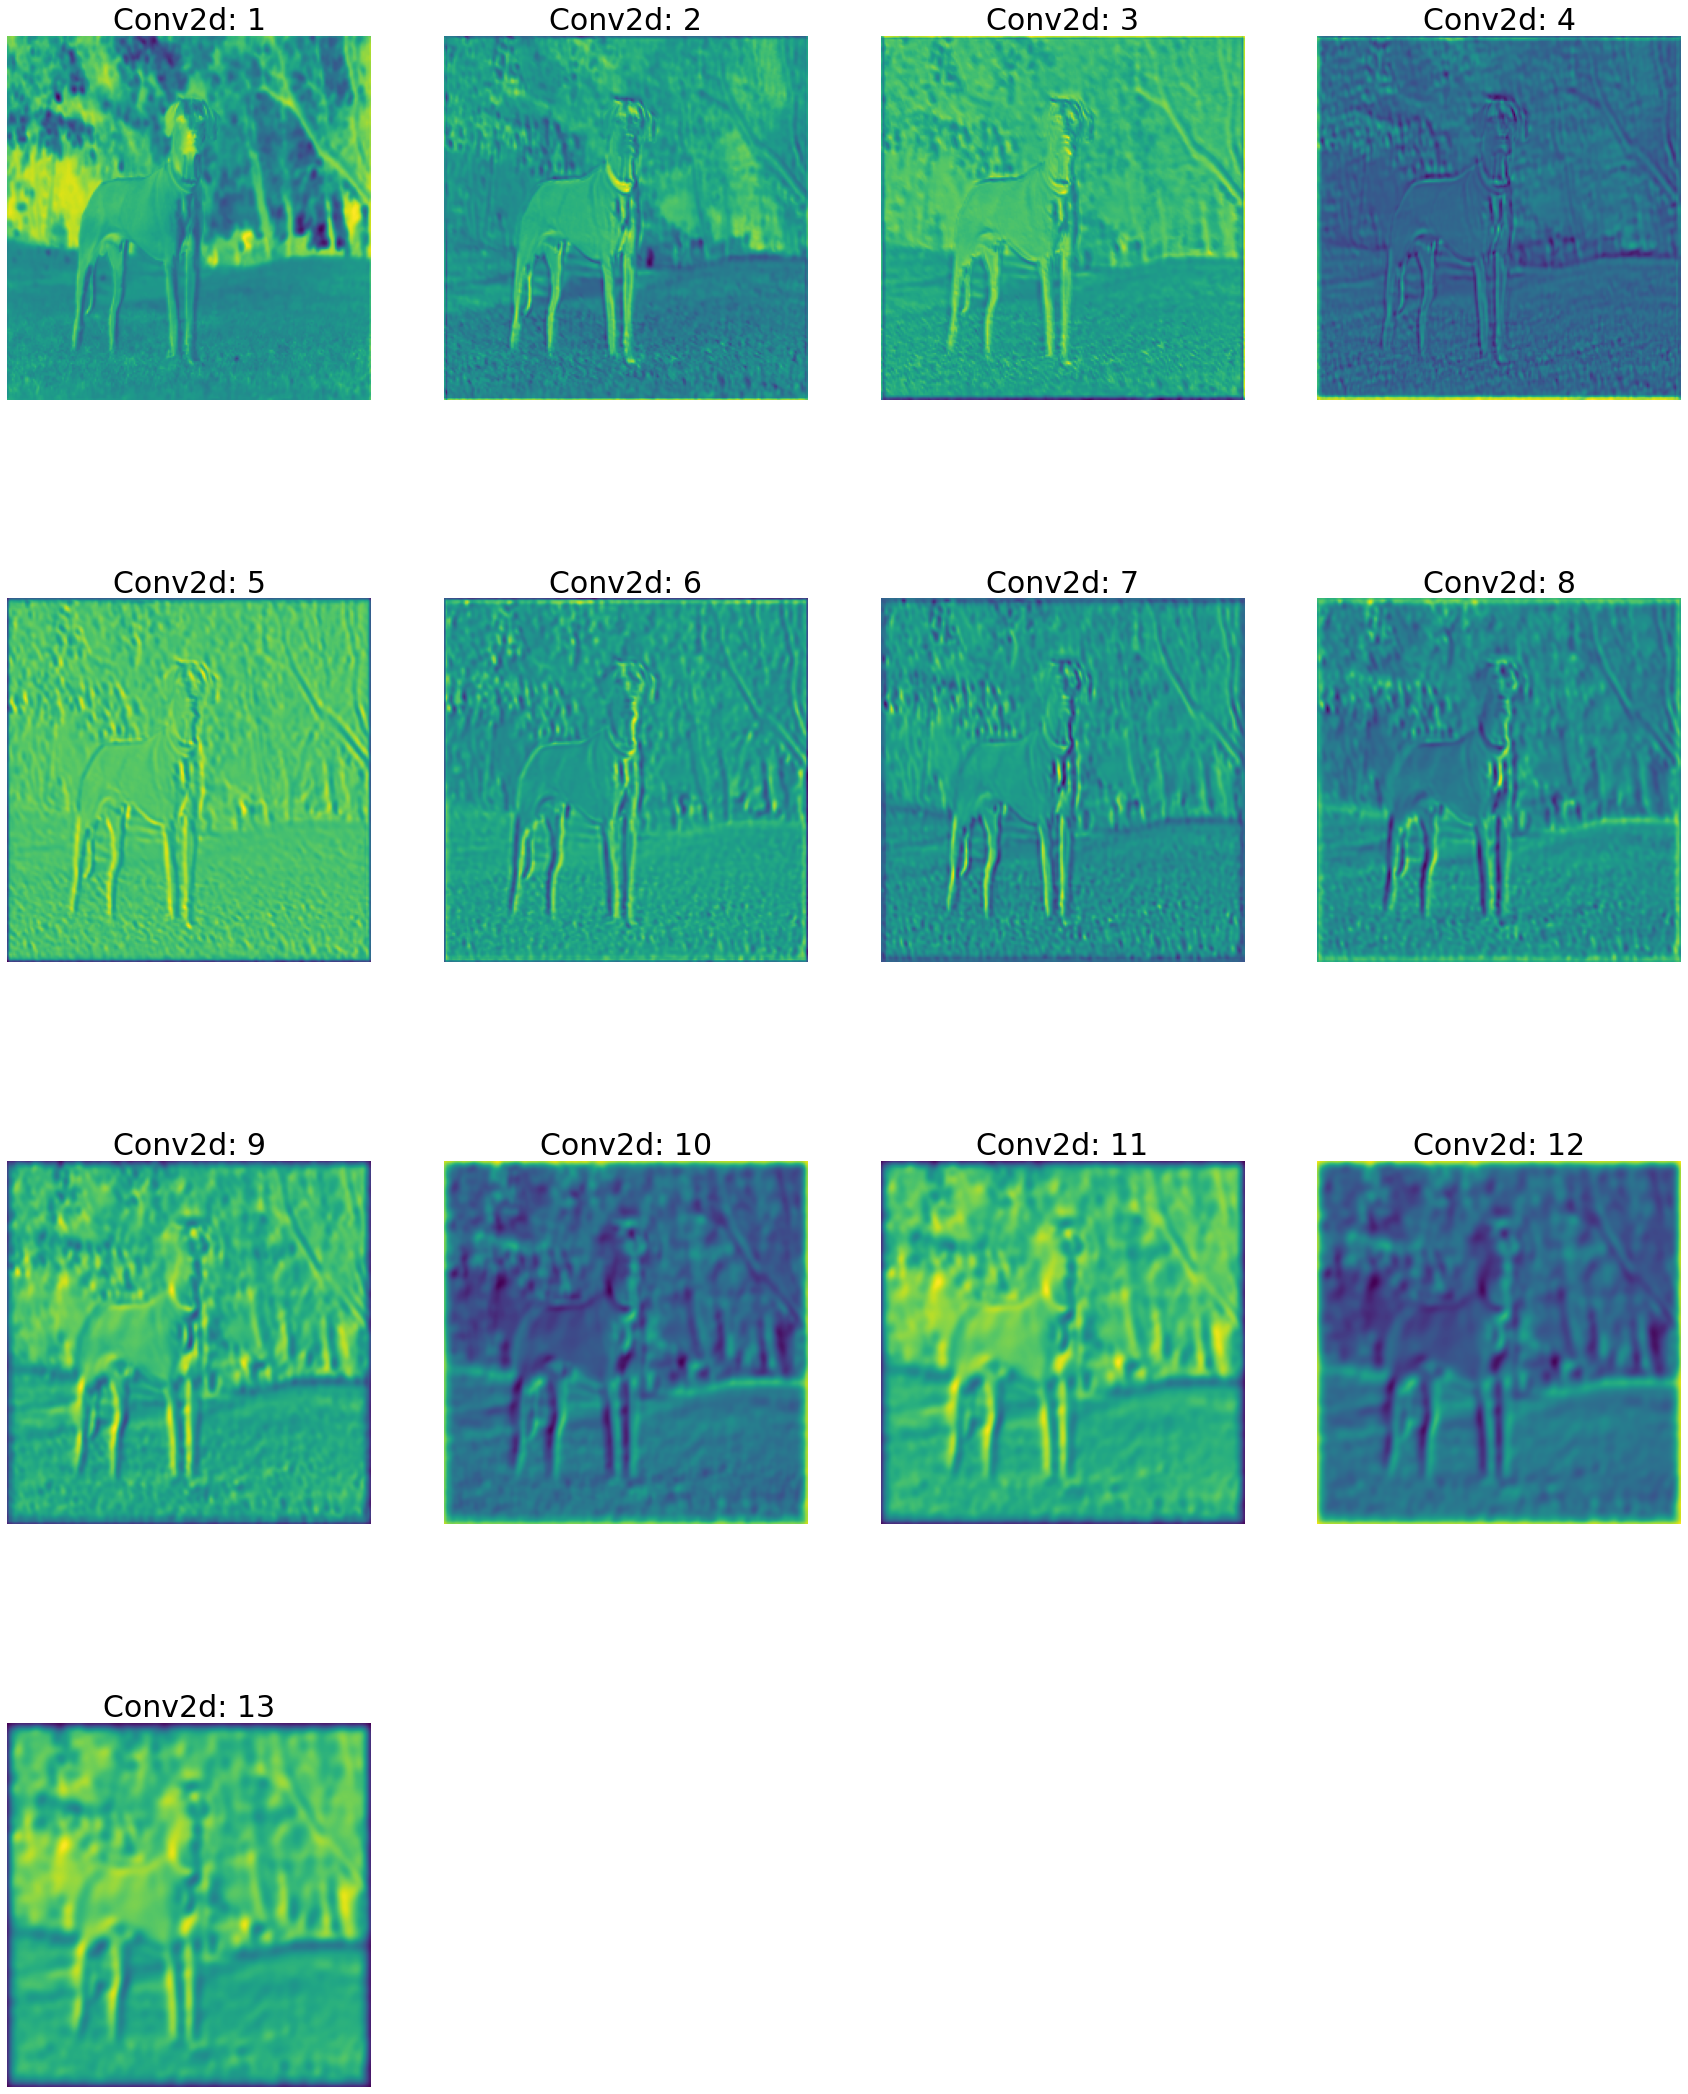

In [19]:
title = [item for item in range(1,14)]
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    # set the title to subplots
    
    a.axis("off")
    a.set_title(names[i].split('(')[0]+": "+str(title[i]), fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

#geometric feature (2,4,7)

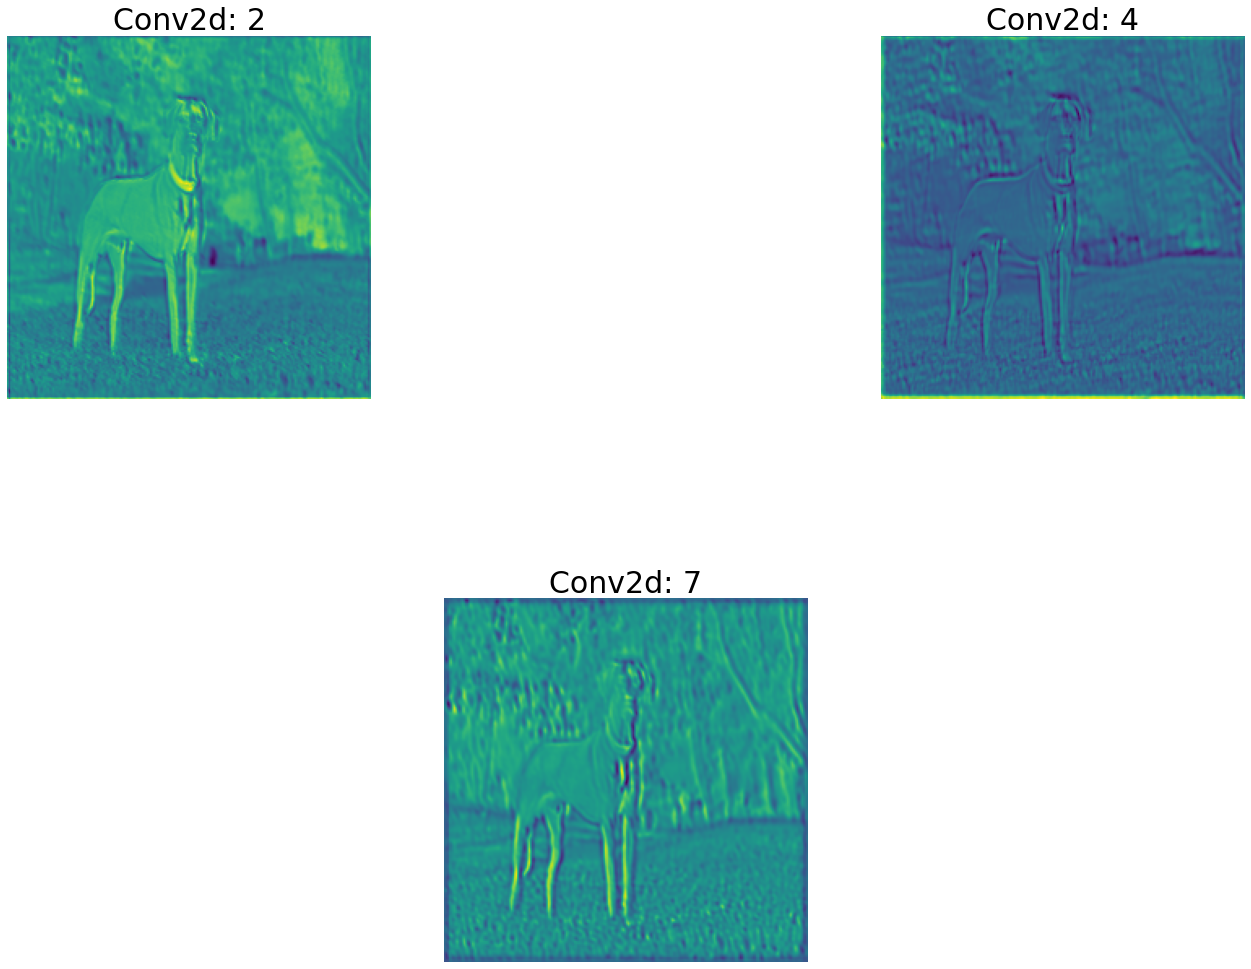

In [26]:
title = [item for item in range(1,14)]
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
  if(i in [1,3,6]):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    # set the title to subplots
    
    a.axis("off")
    a.set_title(names[i].split('(')[0]+": "+str(title[i]), fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

#semantic feature (7,10,13)

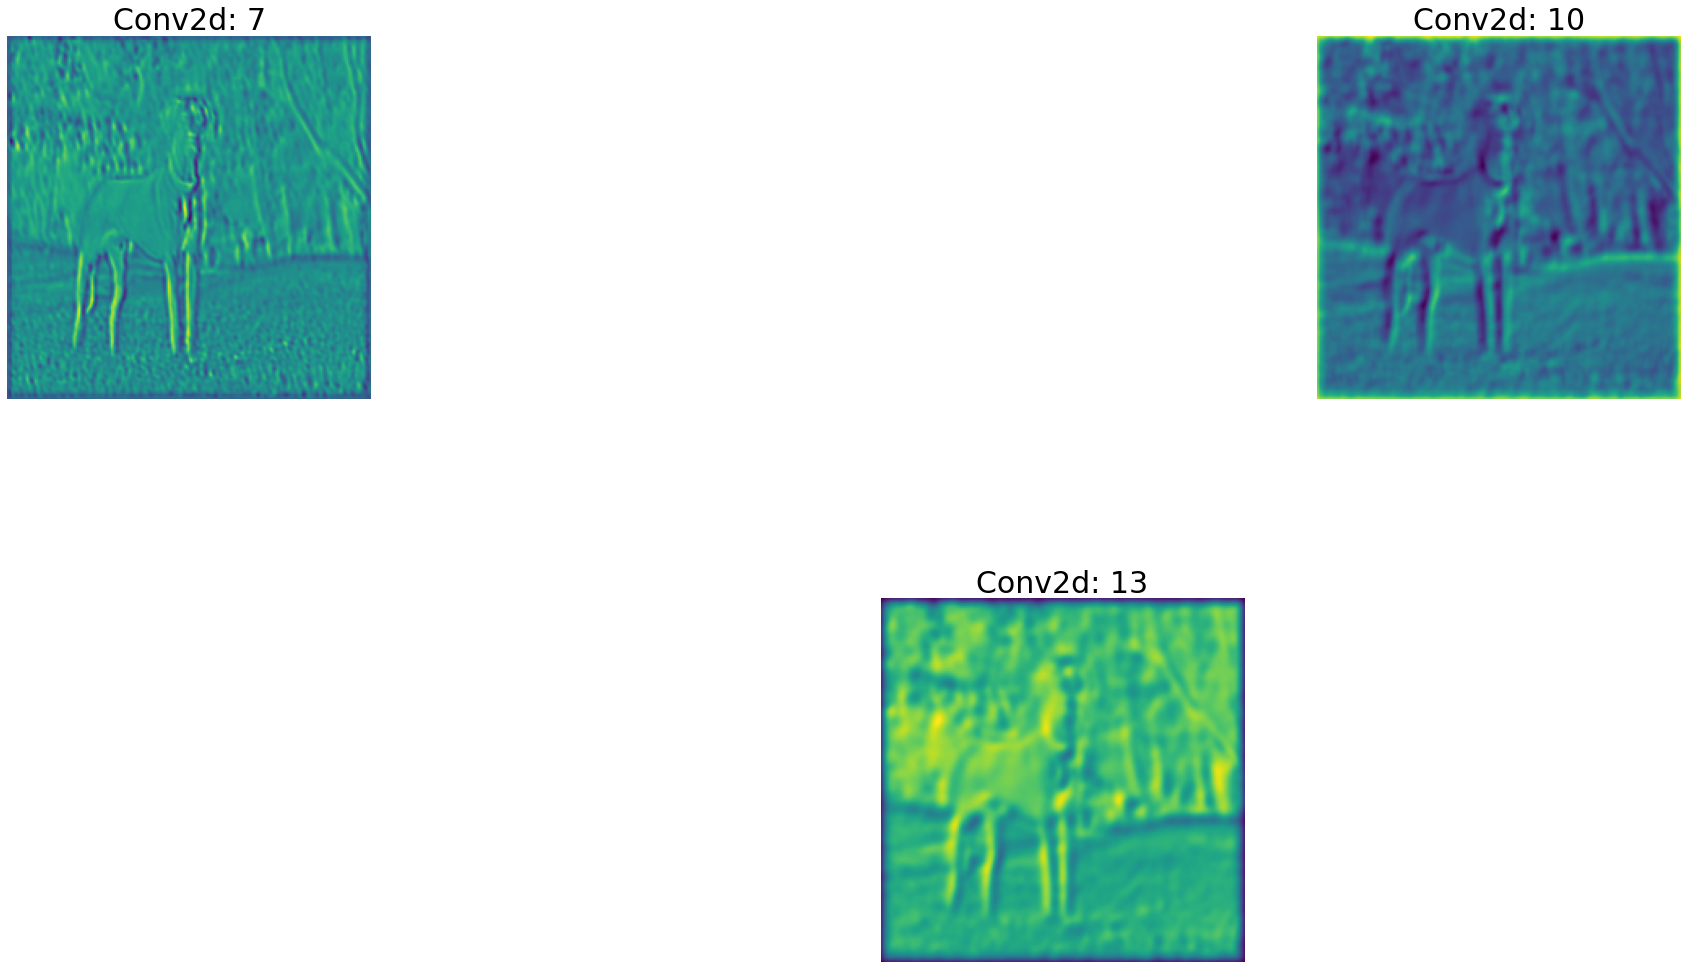

In [24]:
title = [item for item in range(1,14)]
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
  if(i in [6,9,12]):
    a = fig.add_subplot(5, 4, i-5)
    imgplot = plt.imshow(processed[i])
    # set the title to subplots
    
    a.axis("off")
    a.set_title(names[i].split('(')[0]+": "+str(title[i]), fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')